In [177]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split

In [178]:
data_raw = pd.read_csv("../Data/cns_data.csv")   #Using Pandas for data manipulation

In [179]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

Here are the actual diagnoses:

In [180]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [181]:
#Split up 'incdate' into month, day, and year. Monthday is meant to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['year'] = pd.DatetimeIndex(data_df['incdate']).year
data_df['monthday'] = data_df['month']*30+data_df['day']

In [182]:
data_df.labdiag.unique()

array(['malaria', '0.0', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [183]:
data_df2012 = data_df.loc[data_df['year']==2012]
data_df2011 = data_df.loc[data_df['year']==2011]
data_df2010 = data_df.loc[data_df['year']==2010]
data_df2009 = data_df.loc[data_df['year']==2009]

print '2012:',len(data_df2012),'2011:', len(data_df2011), '2010:',len(data_df2010), '2009:', len(data_df2009)

2012: 121 2011: 167 2010: 143 2009: 49


In [184]:
#Select input features
#6-8 adding inclusion criteria and rdttest MLW
clin_df = data_df.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh','incpurp',\
                         'malaria', #is malaria confirmed? I'm assuming this is the rapid diagnostic but idk
                          'diag']] #This is the final diagnosis - will be the 'label'

In [185]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
#clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
#clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth #total age in months


#Medical history variables
clin_df['mhhosp'] = clin_df.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

clin_df['mhdevsp'] = clin_df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
clin_df['incirrit'] = clin_df.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['inchead'] = clin_df.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incphoto'] = clin_df.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incfont'] = clin_df.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incneuro'] = clin_df.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseiza'] = clin_df.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseizh'] = clin_df.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incpurp'] = clin_df.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})

#Malaria diagnositc
clin_df['malaria'] = clin_df.malaria.map({'confirmed':2,'probable':1,'no':0})


#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':3,'crypto':2, '0.0':4})

In [186]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [187]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

print(clin_df.dimain.unique())

[0. 1. 2. 3.]


In [188]:
#Pick the features to classify with.
Xlabels = ['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clinhepato','clinaids','clinhemmor','clinorcand',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                      'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','malaria'] #This is just for plotting.
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clinhepato','clinaids','clinhemmor','clinorcand',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh','incpurp',\
                      'malaria',
                      'diag']]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [189]:
#Get things into the correct format for scikit-learn. I've tried to use the convention throughout that variables
#ending in 'pd' are pandas dataframes.
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)                     #checking that there are a reasonable number of cases left

361


In [190]:
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()

In [191]:
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)
print(np.shape(X))

(361, 46)


In [192]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 45 (0.316850)
2. feature 0 (0.052105)
3. feature 2 (0.051241)
4. feature 20 (0.038258)
5. feature 5 (0.030489)
6. feature 1 (0.028418)
7. feature 24 (0.026519)
8. feature 27 (0.026117)
9. feature 7 (0.023277)
10. feature 6 (0.022733)


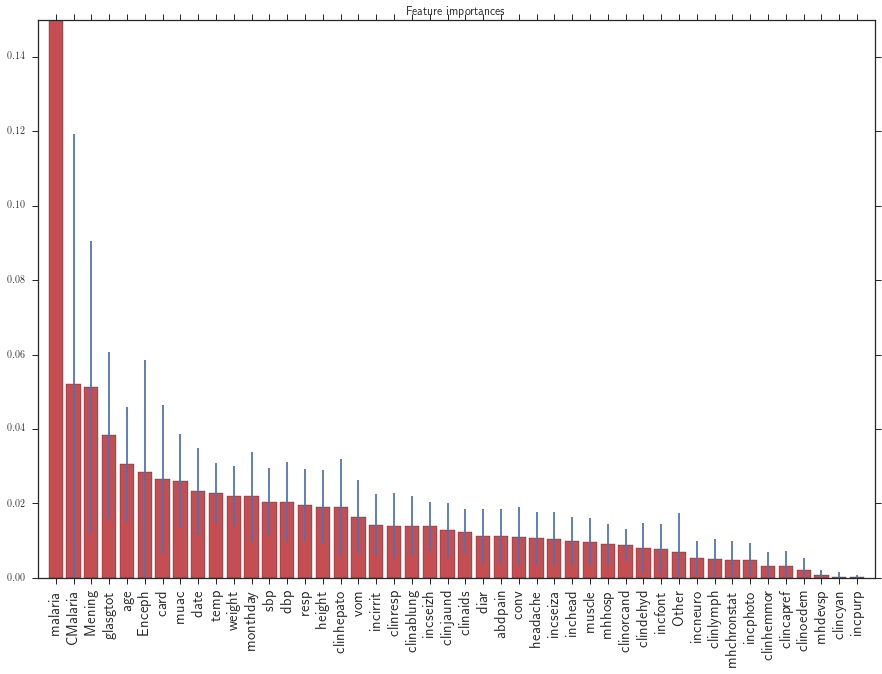

In [193]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [194]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [195]:
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[24  0  0  0  2]
 [ 0  4  0  0  8]
 [ 0  0  0  0  3]
 [ 0  0  0  0  1]
 [ 0  4  0  0 27]]
             precision    recall  f1-score   support

        0.0       1.00      0.92      0.96        26
        1.0       0.50      0.33      0.40        12
        2.0       0.00      0.00      0.00         3
        3.0       0.00      0.00      0.00         1
        4.0       0.66      0.87      0.75        31

avg / total       0.72      0.75      0.73        73



In [196]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

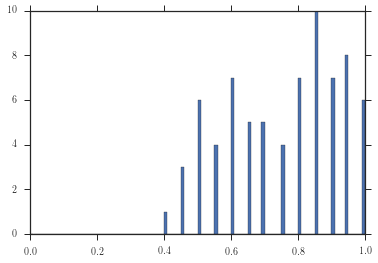

In [197]:
a,b,c = plt.hist(probmax,bins=edges)

In [326]:
def datamap(df,params):
    #Adjust some things that are always included and may need to be used:
    df['dimain'] = df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                                   "Other":3})
    df['incdate'] = pd.to_datetime(df['incdate'])
    df['date'] = (df['incdate'] - df['incdate'].min())  / np.timedelta64(1,'D')
    for label in params:
        #Mapping yes/no to 1/0
        if label=='clinjaund':
            df[label] = df.clinjaund.map({'Yes': 1, 'No': 0})
        if label=='clinhepato':
            df[label] = df.clinhepato.map({'Yes': 1, 'No': 0})
        if label=='clinspleno':
            df[label] = df.clinspleno.map({'Yes': 1, 'No': 0})
        if label=='clinconv':
            df['clinconv'] = df.clinconv.map({'Yes': 1, 'No': 0})
        if label=='clindehyd':
            df['clindehyd'] = df.clindehyd.map({'Yes': 1, 'No': 0})
        if label=='clinnoedem':
            df['clinoedem'] = df.clinoedem.map({'Yes': 1, 'No': 0})
        if label=='clinlymph':
            df['clinlymph'] = df.clinlymph.map({'Yes': 1, 'No': 0})
        if label=='clinresp':
            df['clinresp'] = df.clinresp.map({'Yes': 1, 'No': 0})
        if label=='clinablung':    
            df['clinablung'] = df.clinablung.map({'Yes': 1, 'No': 0})
        if label=='clincyan':
            df['clincyan'] = df.clincyan.map({'Yes': 1, 'No': 0})
        if label=='clincapref':
            df['clincapref'] = df.clincapref.map({'Yes': 1, 'No': 0})
        if label=='clincoldext':
            df['clincoldext'] = df.clincoldext.map({'Yes': 1, 'No': 0})
        if label=='clinorcand':
            df['clinorcand'] = df.clinorcand.map({'Yes': 1, 'No': 0})
        if label=='clinhemmor':
            df['clinhemmor'] = df.clinhemmor.map({'Yes': 1, 'No': 0})
        if label=='clinaids':
            df['clinaids'] = df.clinaids.map({'Yes': 1, 'No': 0})
        if label=='vom':
            df['vom'] = df.vom.map({'Yes': 1, 'No': 0})
        if label=='diar':
            df['diar'] = df.diar.map({'Yes': 1, 'No': 0})
        if label=='headache':
            df['headache'] = df['head'] #Since 'head' is a function
            df['headache'] = df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='conv':
            df['conv'] = df.conv.map({'Yes': 1, 'No': 0})
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months

        #Medical history variables
        if label=='mhhosp':
            df['mhhosp'] = df.mhhosp.map({'Yes': 1, 'No':0})

        #some slightly more compliated mappings
        if label=='abdpain':
            df['abdpain'] = df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='muscle':
            df['muscle'] = df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='mhdevsp':
            df['mhdevsp'] = df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
                   'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
                   'SPEECH DEVELOPEMENTAL DELAY':1})

        #Mapping of inclusion variables 6-8 MLW
        if label=='incirrit':
            df['incirrit'] = df.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='inchead':
            df['inchead'] = df.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incphoto':
            df['incphoto'] = df.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incfont':
            df['incfont'] = df.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incneuro':
            df['incneuro'] = df.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incseiza':
            df['incseiza'] = df.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incseizh':
            df['incseizh'] = df.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='incpurp':
            df['incpurp'] = df.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})

        #Malaria diagnostic
        if label=='malaria':
            df['malaria'] = df.malaria.map({'confirmed':2,'probable':1,'no':0})
        
        #Initial diagnosis coding:
        if label=='CMalaria':
            df['CMalaria'] = df.dimain.map({0:1,1:0,2:0,3:0})
        if label=='Enceph':
            df['Enceph'] = df.dimain.map({0:0,1:1,2:0,3:0})
        if label=='Mening':
            df['Mening'] = df.dimain.map({0:0,1:0,2:1,3:0})
        if label=='Other':
            df['Other'] = df.dimain.map({0:0,1:0,2:0,3:1})


        #This coding is going to be important. You'll want to figure out which categories are useful, and which
        #are practical.
        if label=='diag':
            df['diag'] = df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                                'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                                'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                                'tb':3,'crypto':2, '0.0':4})


In [354]:
Top20 = PlotLabels[:16]
print Top20
Top20 = ['malaria', 'CMalaria', 'Mening', 'age', 'Enceph', 'card', 'muac',
 'date', 'temp', 'weight', 'monthday', 'sbp', 'dbp', 'resp','height']
formapping = ['agemth','ageyrs','incdate','dimain']
TopPlus = np.append(Top20,[formapping])
TopPlus = np.append(TopPlus,['diag'])
print TopPlus

['malaria' 'CMalaria' 'Mening' 'glasgtot' 'age' 'Enceph' 'card' 'muac'
 'date' 'temp' 'weight' 'monthday' 'sbp' 'dbp' 'resp' 'height']
['malaria' 'CMalaria' 'Mening' 'age' 'Enceph' 'card' 'muac' 'date' 'temp'
 'weight' 'monthday' 'sbp' 'dbp' 'resp' 'height' 'agemth' 'ageyrs'
 'incdate' 'dimain' 'diag']


In [359]:
clin_df2012 = data_df2012.loc[:,TopPlus[:]] 
clin_df2011 = data_df2011.loc[:,TopPlus] 
clin_df2010 = data_df2010.loc[:,TopPlus]
clin_df2009 = data_df2009.loc[:,TopPlus]

datamap(clin_df2009,TopPlus)
datamap(clin_df2010,TopPlus)
datamap(clin_df2011,TopPlus)
datamap(clin_df2012,TopPlus)

In [405]:
Xlabels = np.append(Top20,['diag']) #This is just for plotting.
X_pd = clin_df.loc[:,np.append(Top20,['diag'])]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [403]:
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)          
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)
print(np.shape(X))
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

32
(32, 15)
[[3 0]
 [0 4]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         3
        4.0       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         7



In [400]:
indices = indices.astype(int)
topindex = indices[0:10]

In [401]:
for i in topindex:
    print Top20[i]

malaria
age
CMalaria
height
sbp
card
muac
resp
Mening
date


In [591]:
#Now, what happens when you use the N-nearest cases for prediction?
N = 9
Ntot = len(X_pd)
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
cases = np.linspace(N,Ntot-1,Ntot-N)
cases = cases.astype(int)
output = [[0.,0.]]

for a in cases:
    X_train = Features[a-N:a,:]
    X_test = Features[a,:]
    y_train = Labels[a-N:a]
    y_test = Labels[a]
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test.reshape(1,-1))
    output.append([y_test,y_pred[0]])

In [592]:
print len(output)

387


In [593]:
output = np.array(output)
output = output.flatten()
output = np.reshape(output,[Ntot-N+1,2])

In [594]:
y_test = output[:,0]
y_pred = output[:,1]
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[118   4   0   3  12]
 [  1  17   1   1  43]
 [  1   0   0   0   8]
 [  6   1   0   0   2]
 [ 24  33   4   1 107]]
             precision    recall  f1-score   support

        0.0       0.79      0.86      0.82       137
        1.0       0.31      0.27      0.29        63
        2.0       0.00      0.00      0.00         9
        3.0       0.00      0.00      0.00         9
        4.0       0.62      0.63      0.63       169

avg / total       0.60      0.63      0.61       387



In [595]:
Nplot = [10.,15.,20.,25.,30.,35.,50.,60.,70.,80.,90.,100.,150.,200.,250.,125.,175.,225.,5.,6.,7.,8.,9.]
p0 = [0.84,0.89,0.9,0.92,0.91,0.93,0.95,0.93,0.95,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.94,0.64,0.7,0.75,0.76,0.79]
p1 = [0.31,0.3,0.33,0.23,0.26,0.26,0.24,0.36,0.37,0.35,0.28,0.29,0.25,0.33,0.36,0.38,0.32,0.19,0.25,0.25,0.3,0.31,0.31]
p4 = [0.63,0.69,0.69,0.68,0.7,0.69,0.69,0.72,0.73,0.72,0.71,0.72,0.68,0.71,0.69,0.71,0.72,0.69,0.55,0.56,0.59,0.61,0.62]

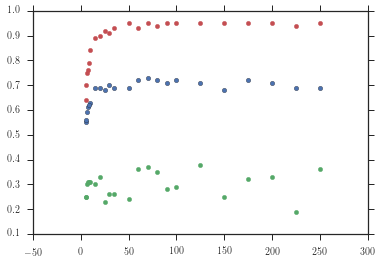

In [596]:
plt.scatter(Nplot,p0,color='r')
plt.scatter(Nplot,p1,color='g')
plt.scatter(Nplot,p4)